In [18]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup

html = open('votingregion2.html').read()
soup = BeautifulSoup(html, "lxml")
soup.encode("cp1251")

dff = pd.read_html('votingregion.html', encoding='utf-8')
h = soup.find_all('table')[2].find_all('tr')[1].find_all('tr')

def cook_soup(url):
	""" возвращает содержимое ответа по заданной ссылке """
	req = requests.get(url)
	soup = BeautifulSoup(req.text, "lxml")
	soup.encode("cp1251")
	return soup

def change_vrn(h):
	url = "http://www.st-petersburg.vybory.izbirkom.ru/region/region/st-petersburg?action=show&root=1&tvd=4784001281120&vrn=&region=78&global=&sub_region=78&prver=0&pronetvd=null&type=220&number=1"
	s = str(h.find_all('a'))
	k = s.index('vrn=')
	k1 = s[k:].index('&')
	vrn = s[k + 4:k + k1]
	url = url[: url.index('vrn=') + 4] + vrn + url[url.index('vrn=') + 4:]
	return url

def name_region(s):
	if s.find('Ульянка') < 0:
		k, k1 = s.find('округ'), s.rfind('шестого')
		k = s.find(' ', k)
		s = s[k + 1 : k1 - 1]
	else: s = "Ульянка"
	return s

def name_district(dff):
	""" Выводит список MO """
	namedis = []
	for i in range(27, 33):
		namedis.append(name_region(dff[7][1][i])) 
	return namedis

def political_party(string):
	party = ''
	if string.find('ЕДИНАЯ РОССИЯ') > 0:
		party = 'ЕДИНАЯ РОССИЯ'
	elif string.find('СПРАВЕДЛИВАЯ РОССИЯ') > 0:
		party = 'СПРАВЕДЛИВАЯ РОССИЯ'
	elif string.find('ПАРТИЯ РОСТА') > 0:
		party = 'ПАРТИЯ РОСТА'
	elif string.find('Коммунистическая партия Российской Федерации') > 0:
		party = 'КПРФ'
	elif string.find('КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ') > 0:
		party = 'КПРФ'
	elif string.find('ЛДПР') > 0:
		party = 'ЛДПР'
	elif string.find('КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ') > 0:
		party = 'КПКР'
	elif string.find('ЯБЛОКО') > 0:
		party = 'ЯБЛОКО'
	elif string.find('Самовыдвижение') >= 0 :
		party = 'Самовыдвижение'
	return party

def munix(s, url):
	information = []
	for i in range(1, s.count('[')+1):
		number = 'number=' + str(i) 
		url = url[: url.index('number=')] + number
		soup = cook_soup(url)
		df = pd.read_html(url, encoding='CP1251')
		df5 = df[5] #инфа про кандидата
		for j in range(len(df5)):
			if df5.iloc[j].iloc[7] =='избр.':
				info = []
				info.append(df5.iloc[j].iloc[1])
				info.append(political_party(df5.iloc[j].iloc[3]))
				information.append(info)
	return information

namedis = []
info = []
for i in range(27, 33): 
	df = []
	namedis.append(name_region(dff[7][1][i]))
	url = change_vrn(h[i + 11])
	df = pd.read_html(url, encoding='CP1251')
	s = df[1].iloc[len(df[1]) - 1].iloc[0]
	info.append(munix(s, url))
hoodinf = {}
for i in range(len(namedis)):
	mas =[]
	d = {}
	for j in range(len(info[i])):
		mas.append(info[i][j][1])
		for g in range(len(mas)):
			k = mas.count(mas[g])
			d[mas[g]] = k
	hoodinf[namedis[i]] = d
print(hoodinf)

{'Морские ворота': {'Самовыдвижение': 4, 'ЕДИНАЯ РОССИЯ': 6}, 'Дачное': {'СПРАВЕДЛИВАЯ РОССИЯ': 1, 'Самовыдвижение': 2, 'ЕДИНАЯ РОССИЯ': 17}, 'Красненькая речка': {'Самовыдвижение': 2, 'ЕДИНАЯ РОССИЯ': 6, 'ЛДПР': 2}, 'Нарвский округ': {'ПАРТИЯ РОСТА': 1, 'ЕДИНАЯ РОССИЯ': 8, 'ЯБЛОКО': 1}, 'Ульянка': {'КПРФ': 4, 'ПАРТИЯ РОСТА': 3, 'СПРАВЕДЛИВАЯ РОССИЯ': 3, 'Самовыдвижение': 1, 'ЕДИНАЯ РОССИЯ': 9}, 'Княжево': {'СПРАВЕДЛИВАЯ РОССИЯ': 2, 'КПКР': 1, 'КПРФ': 1, 'ЕДИНАЯ РОССИЯ': 14, 'ЛДПР': 1}}


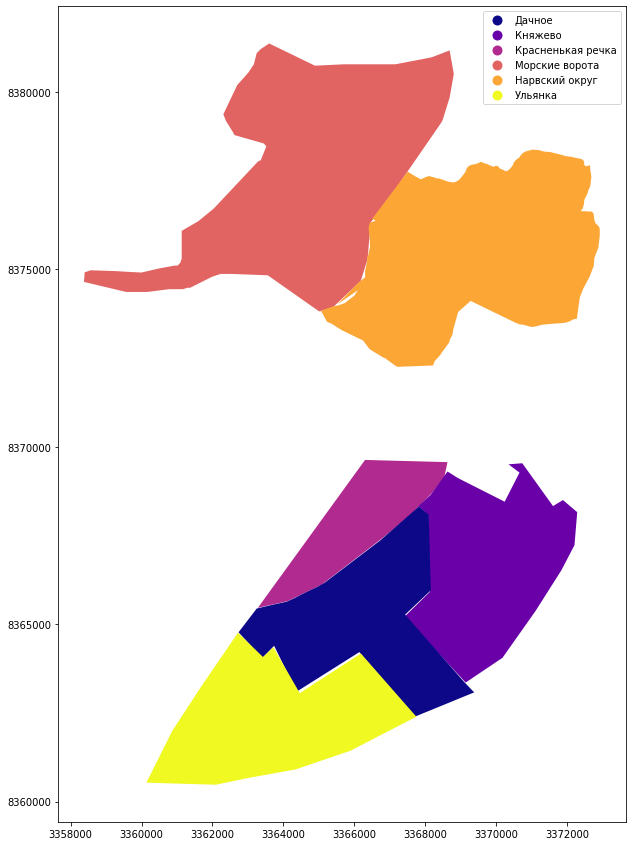

In [53]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('shlasashaposhose.shp', encoding='CP1251')
mo_gdf = mo_gdf.drop([4])
mo_gdf.head()
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = 'Name', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

     id               Name                                           geometry  \
0  None  Красненькая речка  POLYGON ((30.21285 59.84569, 30.24000 59.86450...   
1  None            Княжево  POLYGON ((30.25656 59.86002, 30.26087 59.86303...   
2  None             Дачное  POLYGON ((30.25363 59.85857, 30.25613 59.85754...   
3  None            Ульянка  POLYGON ((30.20782 59.84252, 30.21415 59.83943...   
5  None     Морские ворота  POLYGON ((30.16882 59.88712, 30.16900 59.88834...   
6  None     Нарвский округ  POLYGON ((30.25078 59.90112, 30.25280 59.90050...   

          partia    procent  
0  ЕДИНАЯ РОССИЯ  60.000000  
1  ЕДИНАЯ РОССИЯ  85.000000  
2  ЕДИНАЯ РОССИЯ  60.000000  
3  ЕДИНАЯ РОССИЯ  80.000000  
5  ЕДИНАЯ РОССИЯ  45.000000  
6  ЕДИНАЯ РОССИЯ  73.684211  


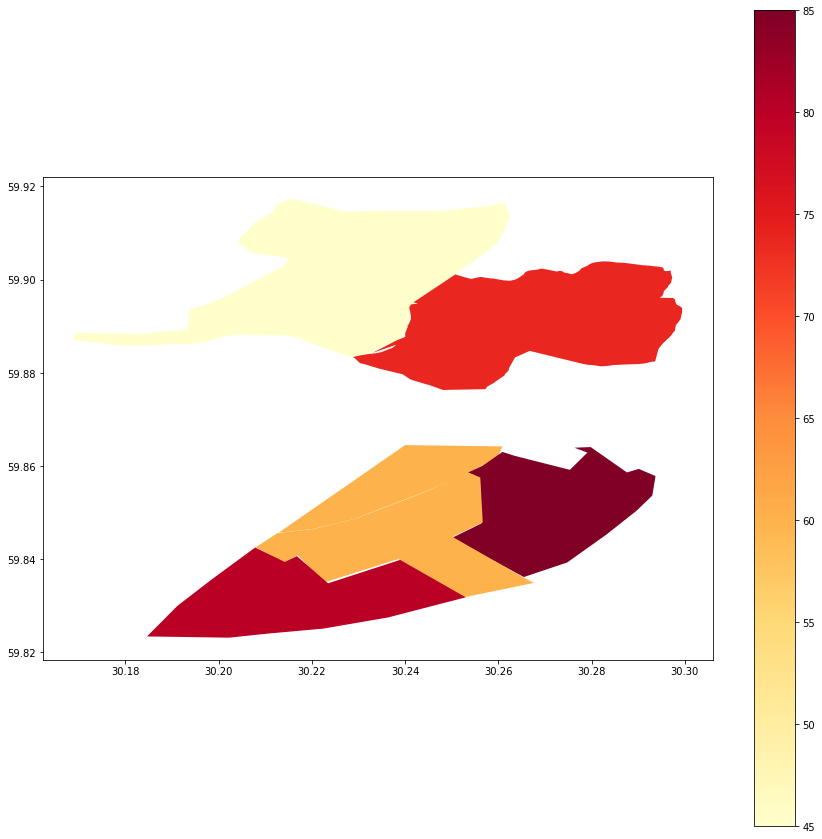

In [51]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('shlasashaposhose.shp', encoding='CP1251')
pobeda = []
procent = []
for i in hoodinf:
    sum = 0
    k = 0
    winner = ''
    for j in hoodinf[i]:
        sum +=hoodinf[i][j]
        if hoodinf[i][j] > k:
            k = hoodinf[i][j]
            winner = j
    pobeda.append(winner)
    procent.append(k * 100 / sum)
mo_gdf = mo_gdf.drop([4])
mo_gdf['partia'] = pobeda
mo_gdf['procent'] = procent
print(mo_gdf)
mo_gdf.plot(column = 'procent', linewidth=0, cmap='YlOrRd', legend=True, figsize=[15,15])